# Bang-Singular-Bang problem and callback

* Author: Olivier Cots
* Date: February 2022

------

## Description of the optimal control problem

We consider the following optimal control problem:

$$ 
    \left\{ 
    \begin{array}{l}
        \displaystyle J(u)  := \displaystyle \int_0^{t_f} x^2(t) \, \mathrm{d}t \longrightarrow \min \\[1.0em]
        \dot{x}(t) = f(x(t), u(t)) := \displaystyle u(t), \quad  |u(t)| \le 1, \quad t \in [0, t_f] \text{ a.e.},    \\[1.0em]
        x(0) = 1, \quad x(t_f) = 1/2.
    \end{array}
    \right. 
$$

To this optimal control problem is associated the stationnary optimization problem

$$
    \min_{(x, u)} \{~ x^2 ~ | ~  (x, u) \in \mathrm{R} \times [-1, 1],~ f(x,u) = u = 0\}.
$$

The static solution is thus $(x^*, u^*) = (0, 0)$. This solution may be seen as the static pair $(x, u)$ which minimizes 
the cost $J(u)$ under the constraint $u \in [-1, 1]$.
It is well known that this problem is what we call a *turnpike* optimal control problem.
Hence, if the final time $t_f$ is long enough, for instance if $t_f=2$, then the solution is of the following form: 
starting from $x(0)=1$, reach as fast as possible the static solution, stay at the static solution as long as possible before reaching
the target $x(t_f)=1/2$. In this case, the optimal control would be

$$
    u(t) = \left\{ 
    \begin{array}{lll}
        -1            & \text{if} & t \in [0, t_1],     \\[0.5em]
        \phantom{-}0  & \text{if} & t \in (t_1, t_2],   \\[0.5em]
        +1            & \text{if} & t \in (t_2, t_f],
    \end{array}
    \right. 
$$

with $0 < t_1 < t_2 < t_f$. We say that the control is *Bang-Singular-Bang*. A Bang arc corresponds to $u \in \{-1, 1\}$ while a singular control corresponds to $u \in (-1, 1)$. Since the optimal control law is discontinuous, then to solve this optimal control problem by indirect methods and find the *switching times* $t_1$ and $t_2$, we need to implement what we call a *multiple shooting method*. 

<div class="alert alert-warning">

**First goal**

Find the final time $t_f < 2$ such that the singular arc vanishes.
    
</div>

To achieve our goal, we will start solving the problem with $t_f = 2$, then we will decrease the value of the final time
by homtopy and detect thanks to a callback given to the numerical continuation method, when the singular arcs vanishes.


**Preliminaries.**

In [1]:
# import packages
import nutopy as nt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters

t0        = 0.0
x0        = np.array([1.0])
xf_target = np.array([0.5])
tf_init   = 2.0
tf_final  = 1.0

**Maximized Hamiltonians and flows.**

We define first the three control laws $u \equiv \{-1, 0, 1\}$.

In [3]:
# Controls in feedback form
@nt.tools.vectorize(vvars=(1, 2, 3))
def uplus(t, x, p):
    u = +1.0
    return u

@nt.tools.vectorize(vvars=(1, 2, 3))
def uminus(t, x, p):
    u = -1.0
    return u

@nt.tools.vectorize(vvars=(1, 2, 3))
def using(t, x, p):
    u = 0.0
    return u

The pseudo-Hamiltonian is
$$
    H(x,p,u) = pu - x^2.
$$

In [4]:
# Definition of the Hamiltonian, its derivatives 
# and the associated flow in the case u = 1
#
def dhfunplus(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    u  = uplus(t, x, p)
    hd = u*dp - 2.0*x*dx
    return hd
    
def d2hfunplus(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd    = -2.0 * d2x * dx
    return hdd

@nt.tools.tensorize(dhfunplus, d2hfunplus, tvars=(2, 3))
def hfunplus(t, x, p):
    u = uplus(t, x, p)
    h = p*u - x**2
    return h

hplus = nt.ocp.Hamiltonian(hfunplus)
fplus = nt.ocp.Flow(hplus)

In [5]:
# Definition of the Hamiltonian, its derivatives 
# and the associated flow in the case u = -1
def dhfunminus(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    u  = uminus(t, x, p)
    hd = u*dp - 2.0*x*dx
    return hd
    
def d2hfunminus(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd    = -2.0 * d2x * dx
    return hdd

@nt.tools.tensorize(dhfunminus, d2hfunminus, tvars=(2, 3))
def hfunminus(t, x, p):
    u = uminus(t, x, p)
    h = p*u - x**2
    return h

hminus = nt.ocp.Hamiltonian(hfunminus)
fminus = nt.ocp.Flow(hminus)

**The shooting function.**

The multiple shooting function is given by

$$
 S(t_1, t_2) := 
 \begin{pmatrix}
     x(t_0, t_1, 0, 0, u_-) - 1       \\
     x(t_f, t_2, 0, 0, u_+) - 1/2
 \end{pmatrix},
$$

where z(t, s, a, b, u) is the solution at time $t$ of the Hamiltonian system associated to the control u starting at time $s$ at the initial condition $z(s) = (a,b)$.

We have introduced the notation $u_-$ for $u\equiv -1$ and $u_+$ for $u\equiv +1$.

**_Remark:_** We know that $(x(t_1), p(t_1))=(x(t_2), p(t_2))=(0,0)$.

In [6]:
# Shooting function
#
def shoot(y, tf):
    t1 = y[0]
    t2 = y[1]
    
    zero   = np.zeros([1,])
    xi, pi = fminus(t1, zero, zero, t0)  # on [t1, t0]
    xf, pf =  fplus(t2, zero, zero, tf)  # on [t2, tf]
    
    s = np.zeros([2])
    s[0] = xi[0] - x0[0]
    s[1] = xf[0] - xf_target[0]  # x(tf, x0, p0) - xf_target
    
    return s

# Derivative of the shooting function
#
def dshoot(y, dy, tf, dtf):
    t1  = y[0]
    t2  = y[1]
    dt1 = dy[0]
    dt2 = dy[1]
    
    zero   = np.zeros([1,])
    (xi, dxi), (pi, dpi) = fminus((t1, dt1), zero, zero, t0)  # on [t1, t0]
    (xf, dxf), (pf, dpf) =  fplus((t2, dt2), zero, zero, (tf, dtf))  # on [t2, tf]
    
    #
    s    = np.zeros([2])
    s[0] = xi[0] - x0[0]
    s[1] = xf[0] - xf_target[0]  # x(tf, x0, p0) - xf_target
    
    # ds
    ds    = np.zeros([2])
    ds[0] = dxi[0]
    ds[1] = dxf[0]
    
    return s, ds

shoot  = nt.tools.tensorize(dshoot, tvars=(1, 2), full=True)(shoot)

**Resolution of the shooting equation.**

The shooting method consists in solving the *shooting equation* $S(t_1, t_2) = 0$.

In [7]:
# Initial guess for the Newton solver
# The initial guess given here is exactly the solution
tf       = tf_init # the associated optimal solution is of the form -0+
t1_guess = 1.0
t2_guess = 1.5

#
fun  = lambda y     :  shoot(y, tf)
dfun = lambda y, dy : dshoot(y, dy, tf, 0.0)
fun  = nt.tools.tensorize(dfun, tvars=(1, ), full=True)(fun)

# Resolution of the shooting equation
y_guess  = np.array([t1_guess, t2_guess])
sol_nle  = nt.nle.solve(fun, y_guess, df=fun)


     Calls  |f(x)|                 |x|
 
         1  2.482534153247273e-16  1.802775637731995e+00
         2  1.110223024625157e-16  1.802775637731995e+00

 Results of the nle solver method:

 xsol    =  [1.  1.5]
 f(xsol) =  [0.00000000e+00 1.11022302e-16]
 nfev    =  2
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.



In [8]:
# function to plot solution
def plot_solution(t1, t2, tf):

    N      = 20
    
    tspan1  = list(np.linspace(t1, t0, N+1))
    tspan2  = (t1, t2)
    tspanf  = list(np.linspace(t2, tf, N+1))
        
    zero    = np.zeros([1,])
    
    x1, p1 = fminus(t1, zero, zero, tspan1)  # on [ 0, t1]
    x2     = np.array([zero, zero])
    p2     = np.array([zero, zero])
    xf, pf = fplus(t2, zero, zero, tspanf)  # on [t2, tf]
    
    u1     = uminus(tspan1, x1, p1)
    u2     = np.array([0., 0.])
    uf     =  uplus(tspanf, xf, pf)

    fig = plt.figure(dpi=120);
    fig.set_figwidth(9);
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.4, hspace=0.3)
    
    ax  = fig.add_subplot(131);
    ax.set_xlabel('t'); ax.set_ylabel('$x$'); ax.axhline(0, color='k', linewidth=0.5); 
    ax.axvline( 0, color='k', linewidth=0.5); ax.axvline( tf, color='k', linewidth=0.5)
    ax.plot(np.concatenate((np.flip(tspan1), tspan2, tspanf)), np.concatenate((np.flip(x1), x2, xf)))
    
    ax  = fig.add_subplot(132);
    ax.set_xlabel('t'); ax.set_ylabel('$p$'); ax.axhline(0, color='k', linewidth=0.5); 
    ax.axvline( 0, color='k', linewidth=0.5); ax.axvline( tf, color='k', linewidth=0.5)
    ax.plot(np.concatenate((np.flip(tspan1), tspan2, tspanf)), np.concatenate((np.flip(p1), p2, pf)))
    
    ax  = fig.add_subplot(133);
    ax.set_xlabel('t'); ax.set_ylabel('$u$'); ax.axhline(0, color='k', linewidth=0.5); 
    ax.axvline( 0, color='k', linewidth=0.5)
    ax.axvline( tf, color='k', linewidth=0.5)
    ax.axhline(-1, color='k', linewidth=0.5)
    ax.axhline( 1, color='k', linewidth=0.5)
    ax.plot(np.concatenate((np.flip(tspan1), tspan2, tspanf)), np.concatenate((np.flip(u1), u2, uf)))

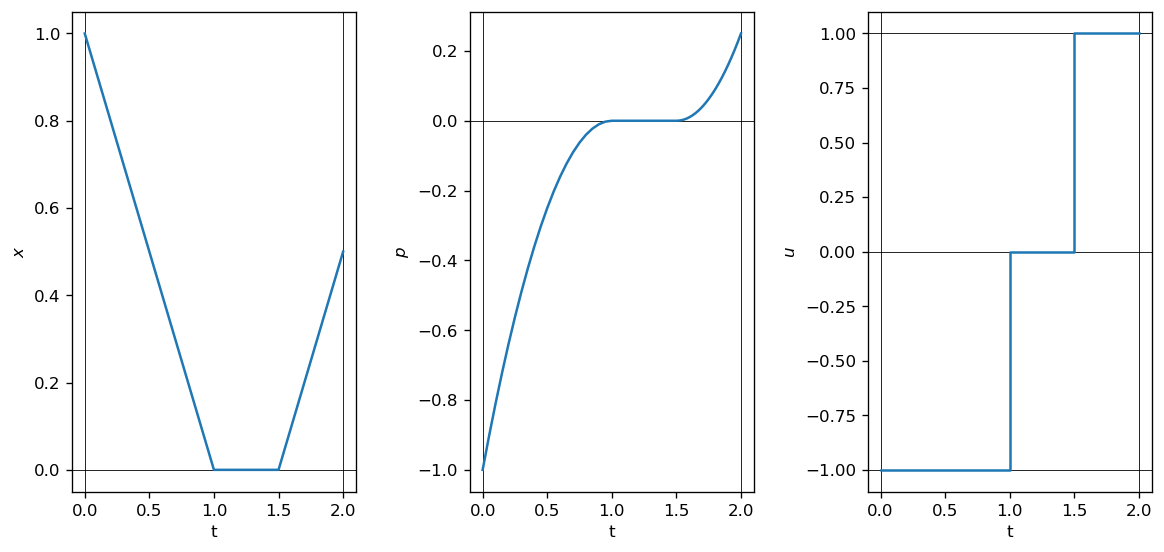

In [9]:
# plot solution
t1_bsb = sol_nle.x[0]
t2_bsb = sol_nle.x[1]
plot_solution(t1_bsb, t2_bsb, tf_init)

**Homotopy on the final time.**

We decrease the final time and check by monitoring if the singular vanishes.

In [10]:
# Homotopy on tf
y0         = sol_nle.x
par0       = np.array([tf_init])
parf       = np.array([tf_final])

# Callback
def check_singular_arc(infos):
    #print('    Switching times: t1 = %e, t2 = %e' % (infos.x[0], infos.x[1]))
    t1 = infos.x[0]
    t2 = infos.x[1]
    status = 0
    if t2<=t1:
        status = -11 # the singular arc has vanished
    return status

opt      = nt.path.Options(MaxStepSizeHomPar=0.2); 
sol_path = nt.path.solve(shoot, y0, par0, parf, df=shoot, callback=check_singular_arc, options=opt)


     Calls  |f(x,pars)|     |x|                Homotopic param    Arclength s     det A(s)        Dot product                
 
         1  1.11022302e-16  1.80277563773e+00  2.00000000000e+00  0.00000000e+00  1.41421356e+00  0.00000000e+00
         2  1.11022302e-16  1.79623308629e+00  1.99213045686e+00  1.11292146e-02  1.41421356e+00  1.00000000e+00
         3  1.11022302e-16  1.73141519318e+00  1.91343502545e+00  1.22421361e-01  1.41421356e+00  1.00000000e+00
         4  1.11022302e-16  1.57239453096e+00  1.71343502545e+00  4.05264069e-01  1.41421356e+00  1.00000000e+00
         4  1.11022302e-16  1.42374525489e+00  1.51343502545e+00  6.88106783e-01  1.41421356e+00  1.00000000e+00
         4  1.11022302e-16  1.28906033242e+00  1.31343502545e+00  9.70949496e-01  1.41421356e+00  1.00000000e+00

 Results of the path solver method:

 xf            =  [1.         0.81343503]
 parsf         =  [1.31343503]
 |f(xf,parsf)| =  1.1102230246251565e-16
 steps         =  6
 status        =  -11

In [11]:
# plot solution
t1_vanish = sol_path.xf[0]
t2_vanish = sol_path.xf[1]
tf_vanish = sol_path.parsf[0]
plot_solution(t1_vanish, t2_vanish, tf_vanish)

We detect that the singular vanishes, that there is a final time $t_f$ such that $t_1=t_2$. For lower values of $t_f$ the
optimal structure becomes of the form Bang-Bang.

In [12]:
# Shooting function for the limit case
#
def shoot_limit(y):
    t1 = y[0]
    t2 = t1
    tf = y[1]
    
    zero   = np.zeros([1,])
    xi, pi = fminus(t1, zero, zero, t0)  # on [t1, t0]
    xf, pf =  fplus(t2, zero, zero, tf)  # on [t2, tf]
    
    s = np.zeros([2])
    s[0] = xi[0] - x0[0]
    s[1] = xf[0] - xf_target[0]  # x(tf, x0, p0) - xf_target
    
    return s

# Derivative of the shooting function
#
def dshoot_limit(y, dy):
    t1  = y[0]
    t2  = t1
    tf  = y[1]
    dt1 = dy[0]
    dt2 = dt1
    dtf = dy[1]
    
    zero   = np.zeros([1,])
    (xi, dxi), (pi, dpi) = fminus((t1, dt1), zero, zero, t0)  # on [t1, t0]
    (xf, dxf), (pf, dpf) =  fplus((t2, dt2), zero, zero, (tf, dtf))  # on [t2, tf]
    
    #
    s    = np.zeros([2])
    s[0] = xi[0] - x0[0]
    s[1] = xf[0] - xf_target[0]  # x(tf, x0, p0) - xf_target
    
    # ds
    ds    = np.zeros([2])
    ds[0] = dxi[0]
    ds[1] = dxf[0]
    
    return s, ds

shoot_limit  = nt.tools.tensorize(dshoot_limit, tvars=(1, ), full=True)(shoot_limit)

In [13]:
# Initial guess
t1_guess = t1_vanish
tf_guess = tf_vanish

# Resolution of the shooting equation
y_guess = np.array([t1_guess, tf_guess])
sol_nle_limit = nt.nle.solve(shoot_limit, y_guess, df=shoot_limit)


     Calls  |f(x)|                 |x|
 
         1  1.865649745493912e-01  1.650791193967439e+00
         2  1.665334536937735e-16  1.802775637731995e+00
         3  1.110223024625157e-16  1.802775637731995e+00
         4  1.110223024625157e-16  1.802775637731995e+00
         5  1.865649745493912e-01  1.960740016773460e+00
         6  1.665334536937735e-16  1.802775637731995e+00
         7  1.110223024625157e-16  1.802775637731995e+00
         8  2.332062181867400e-02  1.822225484636309e+00
         9  1.665334536937735e-16  1.802775637731995e+00
        10  1.110223024625157e-16  1.802775637731995e+00
        11  2.915077727334459e-03  1.805201853217573e+00
        12  1.110223024625157e-16  1.802775637731995e+00
        13  7.287694318335869e-04  1.802169310250673e+00
        14  1.110223024625157e-16  1.802775637731995e+00
        15  1.821923579584661e-04  1.802927233769553e+00
        16  1.665334536937735e-16  1.802775637731995e+00
        17  1.110223024625157e-16  1.802775637

In [14]:
# plot solution
t1_sol = sol_nle_limit.x[0]
t2_sol = t1_sol
tf_sol = sol_nle_limit.x[1]
plot_solution(t1_sol, t2_sol, tf_sol)

[thumbnail](cb.png)